In [1]:
!pip install amazon-textract-response-parser

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:

import boto3
from IPython.display import Image, display
from trp import Document
from PIL import Image as PImage, ImageDraw
import time
from IPython.display import IFrame

# In this section, we will deep dive into Amazon Textract APIs and its feature. 
Amazon Textract includes simple, easy-to-use APIs that can analyze image files and PDF files.
Amazon Textract APIs can be classified into synchronous APIs for real time processing and asynchronous APIs for batch processing.
We will deep dive into each:
•	Synchronous APIs(Real time processing use case)
•	Asynchronous APIs(Batch processing use cases)
Synchronous APIs (Real time processing use case): There are two APIs which can help with real time analysis:
                         Analyze Text 
                         Analyze Document API


In [3]:
# Curent AWS Region. Use this to choose corresponding S3 bucket with sample content

mySession = boto3.session.Session()
awsRegion = mySession.region_name

In [4]:
# S3 bucket that contains sample documents. Download the sample documents and craete an Amazon s3 Bucket 

s3BucketName = "code-in-action"

In [5]:
# Amazon S3 client
s3 = boto3.client('s3')

# Amazon Textract client
textract = boto3.client('textract')

In [6]:
# 1. Detect text from image with

https://docs.aws.amazon.com/textract/latest/dg/API_DetectDocumentText.html

In [7]:
# Document
documentName = "sample-invoice.png"

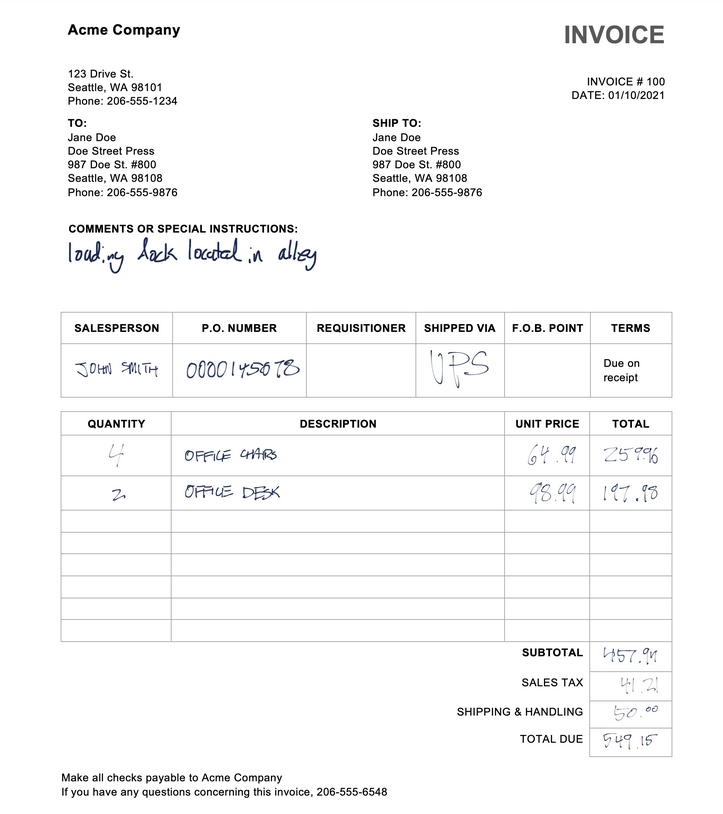

In [8]:
display(Image(filename=documentName))

In [9]:
# Read document content
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())

# Call Amazon Textract
response = textract.detect_document_text(Document={'Bytes': imageBytes})


In [10]:
import json

print (json.dumps(response, indent=4, sort_keys=True))


{
    "Blocks": [
        {
            "BlockType": "PAGE",
            "Geometry": {
                "BoundingBox": {
                    "Height": 1.0,
                    "Left": 0.0,
                    "Top": 0.0,
                    "Width": 0.9993084073066711
                },
                "Polygon": [
                    {
                        "X": 0.0,
                        "Y": 0.0
                    },
                    {
                        "X": 0.9993084073066711,
                        "Y": 1.0877390644358832e-16
                    },
                    {
                        "X": 0.9993084073066711,
                        "Y": 1.0
                    },
                    {
                        "X": 0.0,
                        "Y": 1.0
                    }
                ]
            },
            "Id": "cfa3c4ad-2c8a-4721-8e40-da438eba2816",
            "Relationships": [
                {
                    "Ids": [
                   

# 2. Detect text from S3 object

https://docs.aws.amazon.com/textract/latest/dg/API_DetectDocumentText.html

## Lines and Words of Text - JSON Structure

https://docs.aws.amazon.com/textract/latest/dg/API_BoundingBox.html

https://docs.aws.amazon.com/textract/latest/dg/text-location.html

https://docs.aws.amazon.com/textract/latest/dg/how-it-works-lines-words.html

In [ ]:
#  Reading order

In [11]:
# Document
documentName = "two-column-image.jpeg"

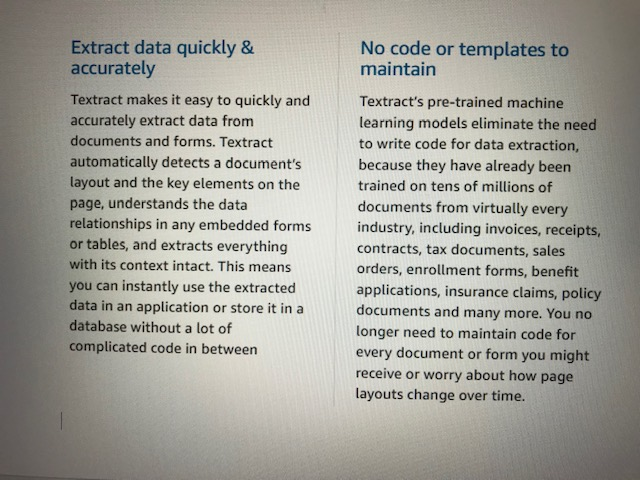

In [12]:
display(Image(filename=documentName))

In [13]:
import boto3

s3 = boto3.resource('s3')
s3.Bucket(s3BucketName).upload_file(documentName,documentName)

In [14]:
# Call Amazon Textract
response = textract.detect_document_text(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    })

print(response)

{'DocumentMetadata': {'Pages': 1}, 'Blocks': [{'BlockType': 'PAGE', 'Geometry': {'BoundingBox': {'Width': 0.8768451809883118, 'Height': 0.8812075257301331, 'Left': 0.07059696316719055, 'Top': 0.05067773535847664}, 'Polygon': [{'X': 0.07295510172843933, 'Y': 0.051235463470220566}, {'X': 0.9447643756866455, 'Y': 0.05067773535847664}, {'X': 0.9474421143531799, 'Y': 0.9286584854125977}, {'X': 0.07059696316719055, 'Y': 0.9318852424621582}]}, 'Id': '41ea03e0-ad9a-4a88-8c3d-5c8eb1cc1028', 'Relationships': [{'Type': 'CHILD', 'Ids': ['79f92d46-8bf1-4bcd-a1e5-2aa64e24ba96', 'c38bd4ea-ab8f-4774-b237-2438b63fce35', '3be6578a-3305-4fb2-bc3f-5488a63e80a3', '22218a59-3bc7-42a5-82c7-4b74d9d18b15', '89c1b59f-ae98-48ac-ae33-e16a24ee9600', '4d57ba69-3ae1-4146-a051-92e44bc9ba79', 'a90bde45-9653-429f-8a93-65c848be5968', '783baf4d-403b-4b05-a22f-a085c5959ae0', 'e601b058-92d1-4f68-816c-df5bedf03e92', '85f19a36-83d6-439e-88d6-0e16663b70fb', '54a6f607-0a8d-4481-b722-b03fc04ca869', '8bd91b1d-d52c-4adb-9282-6c96

In [15]:
#using trp.py to parse the json into reading order
doc = Document(response)
for page in doc.pages:
    for line in page.getLinesInReadingOrder():
          print(line[1])

Extract data quickly &
accurately
Textract makes it easy to quickly and
accurately extract data from
documents and forms. Textract
automatically detects a document's
layout and the key elements on the
page, understands the data
relationships in any embedded forms
or tables, and extracts everything
with its context intact. This means
you can instantly use the extracted
data in an application or store it in a
database without a lot of
complicated code in between
No code or templates to
maintain
Textract's pre-trained machine
learning models eliminate the need
to write code for data extraction,
because they have already been
trained on tens of millions of
documents from virtually every
industry, including invoices, receipts,
contracts, tax documents, sales
orders, enrollment forms, benefit
applications, insurance claims, policy
documents and many more. You no
longer need to maintain code for
every document or form you might
receive or worry about how page
layouts change over time.


# Analyze Document API for tables and Forms: Key/Values

https://docs.aws.amazon.com/textract/latest/dg/API_AnalyzeDocument.html

In [16]:
# Document
documentName = "sample-invoice.png"

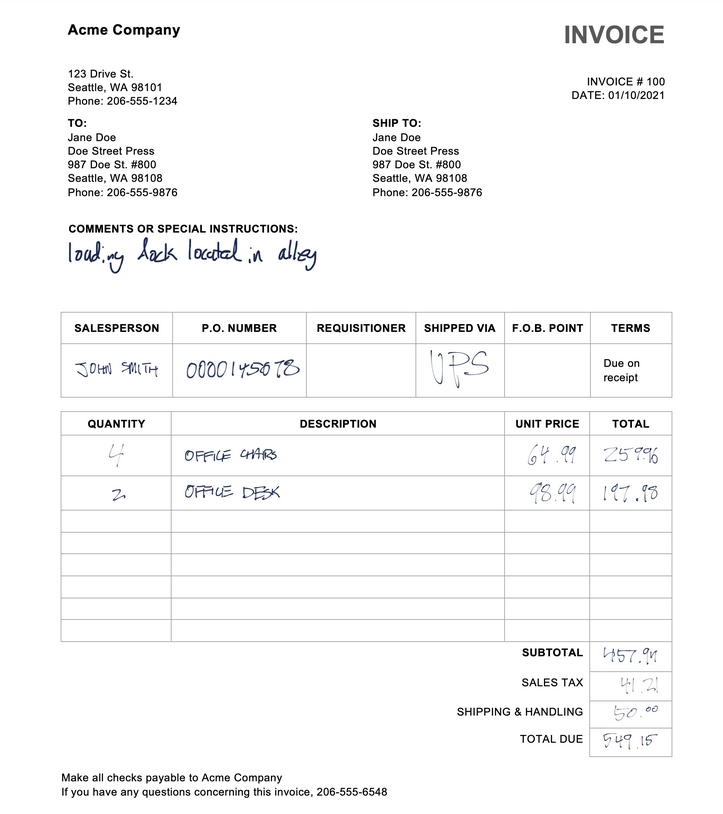

In [17]:
display(Image(filename=documentName))

In [18]:

s3.Bucket(s3BucketName).upload_file(documentName,documentName)

In [19]:
# Call Amazon Textract
response = textract.analyze_document(
    Document={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': documentName
        }
    },
    FeatureTypes=["FORMS","TABLES"])

In [20]:


#print(response)

doc = Document(response)

for page in doc.pages:
    # Print fields
    print("Fields:")
    for field in page.form.fields:
        print("Key: {}, Value: {}".format(field.key, field.value))

    # Get field by key
    print("\nGet Field by Key:")
    key = "Phone Number:"
    field = page.form.getFieldByKey(key)
    if(field):
        print("Key: {}, Value: {}".format(field.key, field.value))

    # Search fields by key
    print("\nSearch Fields:")
    key = "address"
    fields = page.form.searchFieldsByKey(key)
    for field in fields:
        print("Key: {}, Value: {}".format(field.key, field.value))

Fields:
Key: P.O. NUMBER, Value: 0000145078
Key: SUBTOTAL, Value: 457.91
Key: SALESPERSON, Value: JOHIN SMITH
Key: SHIPPING & HANDLING, Value: 50.00
Key: TOTAL DUE, Value: 549.15
Key: DATE:, Value: 01/10/2021
Key: SHIP TO:, Value: Jane Doe Doe Street Press 987 Doe St. #800 Seattle, WA 98108 Phone: 206-555-9876
Key: COMMENTS OR SPECIAL INSTRUCTIONS:, Value: loading lack locatal in alley
Key: SALES TAX, Value: 41.21
Key: SHIPPED VIA, Value: UPS
Key: REQUISITIONER, Value: None
Key: F.O.B. POINT, Value: None
Key: TERMS, Value: Due on receipt
Key: TO:, Value: Jane Doe Doe Street Press 987 Doe St. #800 Seattle, WA 98108 Phone: 206-555-9876
Key: INVOICE #, Value: 100
Key: Phone:, Value: 206-555-1234

Get Field by Key:

Search Fields:


In [21]:
doc = Document(response)

for page in doc.pages:
     # Print tables
    for table in page.tables:
        for r, row in enumerate(table.rows):
            for c, cell in enumerate(row.cells):
                print("Table[{}][{}] = {}".format(r, c, cell.text))

Table[0][0] = QUANTITY 
Table[0][1] = DESCRIPTION 
Table[0][2] = UNIT PRICE 
Table[0][3] = TOTAL 
Table[1][0] = 4 
Table[1][1] = OFFICE GARS 
Table[1][2] = 64.99 
Table[1][3] = 259% 
Table[2][0] = 2 
Table[2][1] = OFFICE DESK 
Table[2][2] = 98.99 
Table[2][3] = 197.98 
Table[3][0] = 
Table[3][1] = 
Table[3][2] = 
Table[3][3] = 
Table[4][0] = 
Table[4][1] = 
Table[4][2] = 
Table[4][3] = 
Table[5][0] = 
Table[5][1] = 
Table[5][2] = 
Table[5][3] = 
Table[6][0] = 
Table[6][1] = 
Table[6][2] = 
Table[6][3] = 
Table[7][0] = 
Table[7][1] = 
Table[7][2] = 
Table[7][3] = 
Table[8][0] = 
Table[8][1] = 
Table[8][2] = 
Table[8][3] = 
Table[9][0] = 
Table[9][1] = 
Table[9][2] = SUBTOTAL 
Table[9][3] = 457.91 
Table[10][0] = 
Table[10][1] = 
Table[10][2] = SALES TAX 
Table[10][3] = 41.21 
Table[11][0] = 
Table[11][1] = SHIPPING 
Table[11][2] = & HANDLING 
Table[11][3] = 50.00 
Table[12][0] = 
Table[12][1] = 
Table[12][2] = TOTAL DUE 
Table[12][3] = 549.15 
Table[0][0] = SALESPERSON 
Table[0][1] = P.

# 12. PDF Processing

https://docs.aws.amazon.com/textract/latest/dg/API_StartDocumentTextDetection.html
https://docs.aws.amazon.com/textract/latest/dg/API_GetDocumentTextDetection.html
https://docs.aws.amazon.com/textract/latest/dg/API_StartDocumentAnalysis.html
https://docs.aws.amazon.com/textract/latest/dg/API_GetDocumentAnalysis.html

In [22]:
def startJob(s3BucketName, objectName):
    response = None
    response = textract.start_document_text_detection(
    DocumentLocation={
        'S3Object': {
            'Bucket': s3BucketName,
            'Name': objectName
        }
    })

    return response["JobId"]

def isJobComplete(jobId):
    response = textract.get_document_text_detection(JobId=jobId)
    status = response["JobStatus"]
    print("Job status: {}".format(status))

    while(status == "IN_PROGRESS"):
        time.sleep(5)
        response = textract.get_document_text_detection(JobId=jobId)
        status = response["JobStatus"]
        print("Job status: {}".format(status))

    return status

def getJobResults(jobId):

    pages = []
    response = textract.get_document_text_detection(JobId=jobId)
    
    pages.append(response)
    print("Resultset page recieved: {}".format(len(pages)))
    nextToken = None
    if('NextToken' in response):
        nextToken = response['NextToken']

    while(nextToken):
        response = textract.get_document_text_detection(JobId=jobId, NextToken=nextToken)

        pages.append(response)
        print("Resultset page recieved: {}".format(len(pages)))
        nextToken = None
        if('NextToken' in response):
            nextToken = response['NextToken']

    return pages

In [23]:
# Document
documentName = "job-application-form.pdf"

In [24]:

s3.Bucket(s3BucketName).upload_file(documentName,documentName)

In [25]:
jobId = startJob(s3BucketName, documentName)
print("Started job with id: {}".format(jobId))
if(isJobComplete(jobId)):
    response = getJobResults(jobId)

#print(response)
doc = Document(response)


Started job with id: d24afcc1dc5c28853a28e8a18c583fe2300387ed5520570424dbc0900def8322
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: IN_PROGRESS
Job status: SUCCEEDED
Resultset page recieved: 1


In [26]:

#Print detected text
for page in doc.pages:
    for line in page.getLinesInReadingOrder():
          print(line[1])

Company Name / Logo
Street XYZ
City, St Zip ABC 0000
Personal Information
Last
First
Jane
Doe
Street Address
1234 Main Street
Are you entitled to work in the United States?
Yes
Have you been convicted of a felony or been incarcerated in connection with a felony in the past seven years?
no
Military Service?
Branch
What position are you applying for?
Expected Hourly Rate
Prior Work Experience
Employer
ABC Corp
Address
1234 Main St
City, ST, ZIP
XYZ
Telephone
5555-XXX
Name of Immediate
Jane Doe Fake
Supervisor
From
Dates of Employment
09/19/2001
Position/Job Title
Executive Assistant
Pay
Reason for Leaving
Not Specified
May We Contact
Education
Name/Location
High School
Fake_School
College/University
Fake_college
Trade School
Other
List any applicable special skills, training
or proficiencies.
Disclaimer - By signing, I hereby certify that the above information, to
the best of my knowledge, is correct. I understand that falsification of
this information may prevent me from being hired or 

# For Analyze expense API demo refer to Chapter 17 Visualizing Insights from handwritten content

# Clean UP

Delete the S3 bucket and sample documents from S3 https://docs.aws.amazon.com/AmazonS3/latest/userguide/delete-objects.html